# Principal Component Analysis Regression

```PCARawBacketest.ipynb``` investigated trading the index based on being *long* each PC signal (equal weight). That proved to be an incorrect assumpption within ```PCASignOLS.ipynb``` which showed that the lag signals carry a small $\beta$ to the return and high p-values. All hope isn't lost although, trading the residuals of the signal (regressing signal against return) generated sizable and repetable profits. This notebook will investigate that model

## Packages

In [1]:
import os
import sys
import numpy as np
import pandas as pd
import statsmodels.api as sm
from   sklearn.decomposition import PCA

import matplotlib.pyplot as plt
from   matplotlib.ticker import FuncFormatter

In [2]:
sys.path.append(r"/Users/diegoalvarez/Desktop/research/FXCarryEconomicSurprise/root/src")
sys.path.append(r"C:\Users\Diego\Desktop\app_prod\research\FXCarryCitiSurprise\root\src")
from CitiPCA import PCAModel

In [3]:
def get_data() -> pd.DataFrame:

    keep_values = "FXCARRSP"

    df_out = (PCAModel().get_misc_indices().query(
        "security == @keep_values").
        pivot(index = "date", columns = "security", values = "rtn").
        merge(right = PCAModel().pca(), how = "inner", on = ["date"]).
        drop(columns = ["explained_variance_ratio"]))
    
    return df_out

df = get_data()

In [4]:
def _get_full_sample_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_tmp = (df.set_index(
        "date").
        sort_index())
    
    model = (sm.OLS(
        endog = df_tmp.FXCARRSP,
        exog  = sm.add_constant(df_tmp.value)).
        fit())
    
    df_params = (model.params.to_frame(
        name = "raw_value").
        reset_index())
    
    df_pvalues = (model.pvalues.to_frame(
        name = "pvalues").
        reset_index())
    
    df_out = (df_params.merge(
        right = df_pvalues, how = "inner", on = ["index"]).
        rename(columns = {"index": "param"}).
        assign(param = lambda x: np.where(x.param == "const", "alpha", "beta")))
    
    return df_out

def get_full_sample_ols(df: pd.DataFrame) -> pd.DataFrame: 
    
    df_params = (df.groupby(
        "pc").
        apply(_get_full_sample_ols).
        reset_index().
        drop(columns = ["level_1"]))
    
    return df_params

df_params = get_full_sample_ols(df)

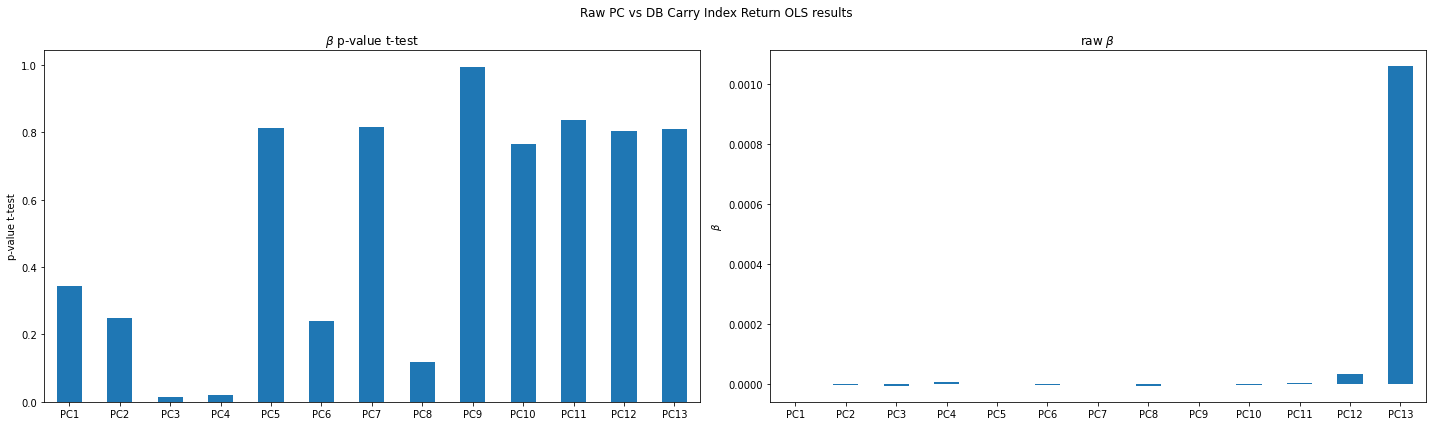

In [5]:
def plot_beta_result(df_params: pd.DataFrame) -> plt.Figure: 
    
    df_longer = (df_params.query(
        "param == 'beta'").
        drop(columns = ["param"]).
        rename(columns = {"value": "raw_value"}).
        melt(id_vars = "pc"))
    
    variables = df_longer.variable.drop_duplicates().sort_values().to_list()
    title_renamer = {
        "pvalues"   : r"$\beta$" + " p-value t-test",
        "raw_value": "raw " + r"$\beta$"}

    ylabel_renamer = {
        "pvalues"   : "p-value t-test",
        "raw_value": r"$\beta$"}

    fig, axes = plt.subplots(ncols = len(variables), figsize = (20,6))

    for variable, ax in zip(variables, axes.flatten()): 

        (df_longer.query(
            "variable == @variable").
            assign(tmp = lambda x: x.pc.str.replace("PC", "").astype(int)).
            sort_values("tmp").
            set_index("pc")
            [["value"]].
            plot(
                ax     = ax,
                kind   = "bar",
                rot    = 0,
                legend = False,
                xlabel = "",
                ylabel = ylabel_renamer[variable],
                title  = title_renamer[variable]))
        
    fig.suptitle("Raw PC vs DB Carry Index Return OLS results")
    plt.tight_layout()
    
plot_beta_result(df_params)

These also fail to meet the conditions for them being acceptable.